# LSTMs for text generation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
import numpy as np

## Downloading stories
Stories are automatically downloaded from https://www.cs.cmu.edu/~spok/grimmtmp/, if not detected in the disk. The total size of stories is around ~500KB. The dataset consists of 209 stories.

In [2]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
dir_name = 'data'

def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right size."""

    # Create directories if they don't exist
    os.makedirs(download_dir, exist_ok=True)

    # If file doesn't exist, download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)

    return filepath

# Number of files and their names to download
# num_files = 209
num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,num_files+1)]

# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)

# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print(f"{len(filenames)} files found.")

100 files found.


## Splitting train, validation, and test data

In [3]:
from sklearn.model_selection import train_test_split

# Fix the random seed so we get the same output every time
random_state = 54321

filenames = [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5, random_state=random_state)

# Print out the sizes and some sample file names
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print(f"Got {len(subset)} files in the {subset_id} dataset (e.g. {subset[:3]})")

Got 108 files in the train dataset (e.g. ['data/128.txt', 'data/054.txt', 'data/101.txt'])
Got 14 files in the valid dataset (e.g. ['data/072.txt', 'data/014.txt', 'data/063.txt'])
Got 14 files in the test dataset (e.g. ['data/049.txt', 'data/131.txt', 'data/106.txt'])


## Finding the vocabulary size

In [4]:
bigram_set = set()

# Go through each file in the training set
for fname in train_filenames:
    document = [] # This will hold all the text
    with open(fname, 'r') as f:
        for row in f:
            # Convert text to lowercase to reduce input dimensionality
            document.append(row.lower())

        # From the list of text we have, generate one long string (containing all training stories)
        document = " ".join(document)

        # Update the set with all bigrams found
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])

# Assign to a variable and print
n_vocab = len(bigram_set)
print(f"Found {n_vocab} unique bigrams")

Found 678 unique bigrams


In [5]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ Generate batched data from a list of files speficied """

    # Read the data found in the documents
    documents = []
    for f in filenames:
        doc = tf.io.read_file(f)
        doc = tf.strings.ngrams(    # Generate n-grams from the string
            tf.strings.bytes_split(    # Create a list of chars from a string
                tf.strings.regex_replace(    # Replace new lines with spaces
                    tf.strings.lower(    # Convert string to lowercase
                        doc
                    ), "\n", " "
                )
            ),
            ngram_width, separator=''
        )
        documents.append(doc.numpy().tolist())

    # documents is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the n-grams (e.g., abcd -> ab, bc, cd) with overlap; however, for our data
    # we do not need the overlap, so we need to skip the overlapping n-grams
    # the following line does that
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])

    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g., ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence, for our model
    doc_dataset = doc_dataset.flat_map(
        lambda x: tf.data.Dataset.from_tensor_slices(
            x
        ).window(
            size=window_size+1, shift=int(window_size * 0.75)
        ).flat_map(
            lambda window: window.batch(window_size+1, drop_remainder=True)
        )
    )

    # From each windowed sequence we generate input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))

    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset

    # Batch the data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)

    # Return the data
    return doc_dataset


ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)

## Generating a few samples from the dataset function

In [6]:
ds = generate_tf_dataset(train_filenames, 2, window_size=10, batch_size=1).take(5)

for record in ds:
    print(record[0].numpy(), '->', record[1].numpy())

[[b'th' b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ']] -> [[b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ' b'a ']]
[[b' u' b'po' b'n ' b'a ' b'ti' b'me' b' a' b' v' b'er' b'y ']] -> [[b'po' b'n ' b'a ' b'ti' b'me' b' a' b' v' b'er' b'y ' b'ol']]
[[b' v' b'er' b'y ' b'ol' b'd ' b'wo' b'ma' b'n,' b' w' b'ho']] -> [[b'er' b'y ' b'ol' b'd ' b'wo' b'ma' b'n,' b' w' b'ho' b' l']]
[[b'n,' b' w' b'ho' b' l' b'iv' b'ed' b' w' b'it' b'h ' b'he']] -> [[b' w' b'ho' b' l' b'iv' b'ed' b' w' b'it' b'h ' b'he' b'r ']]
[[b'it' b'h ' b'he' b'r ' b'fl' b'oc' b'k ' b'of' b' g' b'ee']] -> [[b'h ' b'he' b'r ' b'fl' b'oc' b'k ' b'of' b' g' b'ee' b'se']]


## Defining the model

In [7]:
import tensorflow.keras.backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

### Defining a `TextVectorization` layer

In [8]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

In [9]:
# Print a few bigrams learned by the vectorization layer
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

### Converting the targets from string n-grams to n-gram IDs

In [10]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

In [11]:
lm_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.LSTM(512, return_sequences=True),
    layers.LSTM(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

### Metrics and compilation

In [12]:
# Inspired by https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3
class PerplexityMetric(tf.keras.metrics.Mean):

    def __init__(self, name='perplexity', **kwargs):
      super().__init__(name=name, **kwargs)
      self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

    def _calculate_perplexity(self, real, pred):

      # The next four lines zero out the padding from loss calculations,
      # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics
      loss_ = self.cross_entropy(real, pred)

      # Calculating the perplexity steps:
      step1 = K.mean(loss_, axis=-1)
      perplexity = K.exp(step1)

      return perplexity

    def update_state(self, y_true, y_pred, sample_weight=None):
      perplexity = self._calculate_perplexity(y_true, y_pred)
      # Remember self.perplexity is a tensor (tf.Variable), so using simply "self.perplexity = perplexity" will result in error because of mixing EagerTensor and Graph operations
      super().update_state(perplexity)


In [13]:
lm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])
lm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 128)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 128, 96)           65280     
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1247232   
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          787456    
                                                                 
 dense (Dense)               (None, 128, 1024)         263168    
                                                                 
 dropout (Dropout)           (None, 128, 1024)         0         
                                                        

In [ ]:
lstm_history = lm_model.fit(train_ds, validation_data=valid_ds, epochs=3)

Epoch 1/3


# Inference model
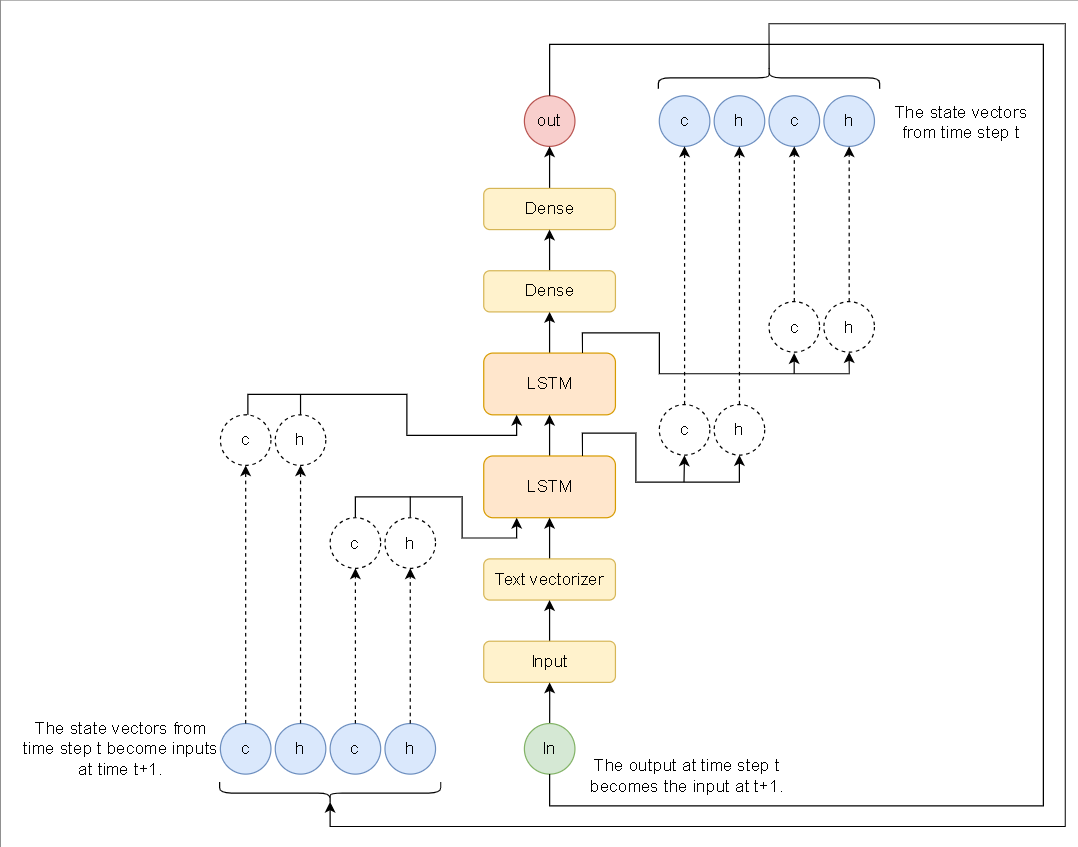

In [ ]:
# Define inputs to the model
inp = tf.keras.layers.Input(dtype=tf.string, shape=(1,))

text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)

inp_state_c_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_h_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_c_lstm_1 = tf.keras.layers.Input(shape=(256,))
inp_state_h_lstm_1 = tf.keras.layers.Input(shape=(256,))

# Define embedding layer and output
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)

# Define an LSTM layers and output
lstm_layer = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state=[inp_state_c_lstm, inp_state_h_lstm])

lstm_1_layer = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
lstm_1_out, lstm_1_state_c, lstm_1_state_h = lstm_1_layer(lstm_out, initial_state=[inp_state_c_lstm_1, inp_state_h_lstm_1])

# Define a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# Define the final Dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)
#softmax_out = tf.keras.layers.Activation(activation='softmax')(final_out)

# Copy the weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())

# Define final model
infer_model = tf.keras.models.Model(
    inputs=[inp, inp_state_c_lstm, inp_state_h_lstm, inp_state_c_lstm_1, inp_state_h_lstm_1],
    outputs=[final_out, lstm_state_c, lstm_state_h, lstm_1_state_c, lstm_1_state_h])


# Summary
infer_model.summary()

In [ ]:
import numpy as np

text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making predictions from a {len(seq)} element long input")

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))

# Reset the state of the model initially
infer_model.reset_states()
# Define the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

# Recursively update the model by assigning new state to state
for c in seq:
    #print(c)
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Code listing 10.7
for _ in range(500):

    # Get the next output and state
    out, state_c, state_h, state_c_1, state_h_1  = infer_model.predict([x, state_c, state_h, state_c_1, state_h_1 ])

    # Get the word ID and the word from out
    out_argsort = np.argsort(out[0], axis=-1).ravel()
    wid = int(out_argsort[-1])
    word = index_word[wid]

    # If the word ends with space, we introduce a bit of randomness
    # Essentially pick one of the top three outputs for that time step depending on their likelihood
    if word.endswith(' '):
        if np.random.normal()>0.5:
            width = 5
            i = np.random.choice(list(range(-width,0)), p=out_argsort[-width:]/out_argsort[-width:].sum())
            wid = int(out_argsort[i])
            word = index_word[wid]

    # Append the prediction
    text.append(word)

    # Recursively make the current prediction the next input
    x = np.array([[word]])

# Print the final output
print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

## Comparing to LSTMs with peepholes and GRUs

In [ ]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_peephole_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(512),
        return_sequences=True
    ),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(256),
        return_sequences=True
    ),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_peephole_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

lstm_peephole_history = lm_peephole_model.fit(train_ds, validation_data=valid_ds, epochs=3)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_gru_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

gru_history = lm_gru_model.fit(train_ds, validation_data=valid_ds, epochs=3)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plots without the Word2vec-related results
plt.figure(figsize=(12, 6))
k = 5

for model_name, history, marker, color in zip(
    ['LSTM', 'LSTM (Peephole)', 'GRU'],
    [lstm_history, lstm_peephole_history, gru_history],
    ['o', '+', 'x'],
    ['red', 'green', 'blue']
):

    train_perplexity = history.history["perplexity"][k:]
    val_perplexity = history.history["val_perplexity"][k:]

    # Plot the training perplexities
    plt.plot(np.arange(k,len(train_perplexity)+k),
               train_perplexity, marker=marker, markersize=6, linestyle='--' , color=color,
               label = model_name)

    plt.plot(np.arange(k, len(val_perplexity)+k),
           val_perplexity, marker=marker, markersize=6, color=color,
           label = model_name+'_valid')

plt.legend(loc=1,fontsize=16)
plt.title('Train/Valid perplexity behavior for various sequential models',fontsize=18)
plt.ylabel('Perplexity',fontsize=18)


## LSTM with beam search

Here we alter the previously defined prediction-related TensorFlow operations to employ beam search. Beam search is a way of prediction several time steps ahead. Instead of predicting the best prediction we have at a given time step, we get predictions for several time steps and get the sequence of highest joint probability.

In [ ]:
def beam_one_step(model, input_, states):
    """ Perform the model update and output for one step"""
    out = model.predict([input_, *states])
    output, new_states = out[0], out[1:]
    return output, new_states


def beam_search(model, input_, states, beam_depth=5, beam_width=3):
    """ Defines an outer wrapper for the computational function of beam search """

    vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
    index_word = dict(zip(range(len(vocabulary)), vocabulary))

    def recursive_fn(input_, states, sequence, log_prob, i):
        """ This function performs actual recursive computation of the long string"""

        if i == beam_depth:
            """ Base case: Terminate the beam search """
            results.append((list(sequence), states, np.exp(log_prob)))
            return sequence, log_prob, states
        else:
            """ Recursive case: Keep computing the output using the previous outputs"""
            output, new_states = beam_one_step(model, input_, states)

            # Get the top beam_width candidates, for the given depth
            top_probs, top_ids = tf.nn.top_k(output, k=beam_width)
            top_probs, top_ids = top_probs.numpy().ravel(), top_ids.numpy().ravel()

            # For each candidate, compute the next prediction
            for p, wid in zip(top_probs, top_ids):
                new_log_prob = log_prob + np.log(p)

                # we are going to penalize joint probability whenever the same symbol is repeating
                if len(sequence)>0 and wid == sequence[-1]:
                    new_log_prob = new_log_prob + np.log(1e-1)

                sequence.append(wid)
                _ = recursive_fn(np.array([[index_word[wid]]]), new_states, sequence, new_log_prob, i+1)
                sequence.pop()


    results = []
    sequence = []
    log_prob = 0.0
    recursive_fn(input_, states, sequence, log_prob, 0)

    results = sorted(results, key=lambda x: x[2], reverse=True)

    return results

In [ ]:
text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))


seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making {len(seq)} predictions from input")


# Reset the state of the model initially
lm_model.reset_states()

# Define the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

states = [state_c, state_h, state_c_1, state_h_1]

# Recursively update the model by assigning new state to state
for c in seq:
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Predict for 100 time steps
for i in range(50):
    print('.', end='')

    # Get the results from beam search
    result = beam_search(infer_model, x, states, 5, 5)

    # Get one of the top 10 results based on their likelihood
    n_probs = np.array([p for _,_,p in result[:10]])
    p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())
    best_beam_ids, states, _ = result[p_j]
    x = np.array([[index_word[best_beam_ids[-1]]]])

    text.extend([index_word[w] for w in best_beam_ids])

print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))